In [1]:
from fastTSNE import TSNE, TSNEEmbedding
from fastTSNE.callbacks import ErrorLogger
from fastTSNE.affinity import PerplexityBasedNN, Multiscale
from fastTSNE import initialization

from examples import utils

import numpy as np
import scipy.sparse as sp
from fbpca import pca
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
import gzip
import pickle

with gzip.open("data/zeisel_2018.pkl.gz", "rb") as f:
    data = pickle.load(f)
    
x_log, x_raw = data["log_counts"], data["counts"]
x_log, x_raw = x_log.T, x_raw.T

y = data["CellType3"]

In [3]:
print('Data set contains %d samples with %d features' % x_log.shape)

Data set contains 160796 samples with 27932 features


### Feature selection

Chosen offset: 0.18


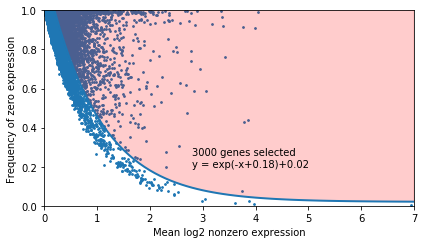

In [4]:
gene_mask = utils.select_genes(x_raw, n=3000)

In [5]:
x = x_log[:, gene_mask]

In [6]:
print('Data set contains %d samples with %d features' % x.shape)

Data set contains 160796 samples with 3000 features


### PCA preprocessing

In [7]:
%time U, S, V = pca(x, k=50)

CPU times: user 29.5 s, sys: 832 ms, total: 30.3 s
Wall time: 22.4 s


In [8]:
x_reduced = np.dot(U, np.diag(S))
x_reduced = x_reduced[:, np.argsort(S)[::-1]][:, :50]

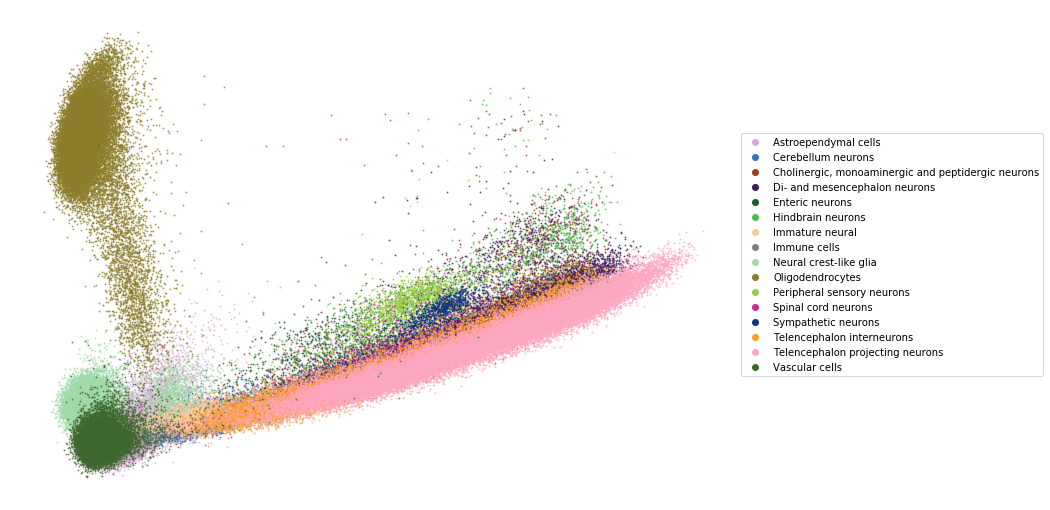

In [9]:
utils.plot(x_reduced[:, :2], y, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

### Ordinary t-SNE

In [10]:
%time affinities = PerplexityBasedNN(x_reduced, perplexity=50, method='approx', n_jobs=8)

CPU times: user 3min 18s, sys: 2.39 s, total: 3min 21s
Wall time: 1min 22s


CPU times: user 27min 34s, sys: 1min 2s, total: 28min 36s
Wall time: 3min 44s


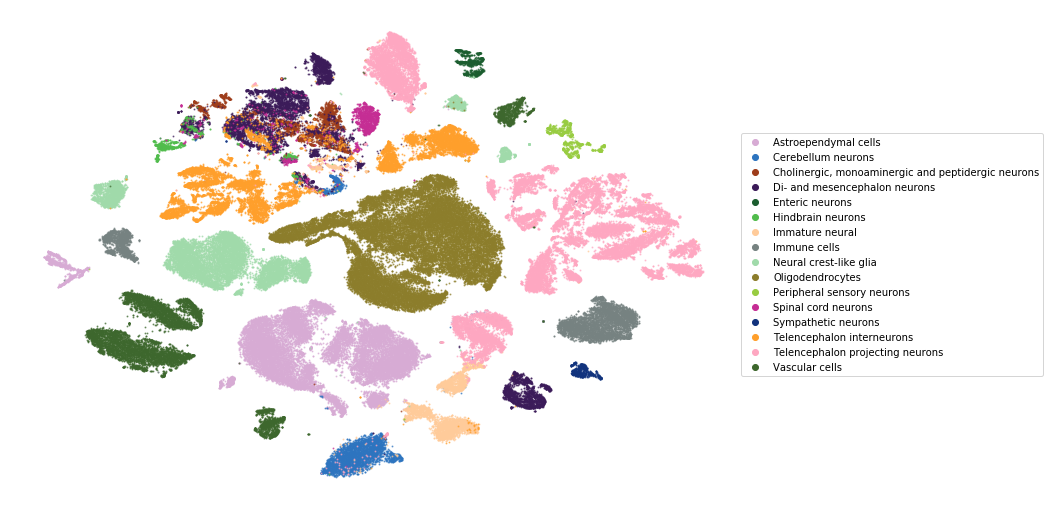

In [11]:
%%time
embedding = TSNEEmbedding(
    initialization.random(x_reduced.shape[0], n_components=2, random_state=np.random.RandomState(42)),
    affinities, negative_gradient_method='fft', learning_rate=1000, n_jobs=8)

embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5, inplace=True)
embedding.optimize(n_iter=1000, momentum=0.8, inplace=True)

utils.plot(embedding, y, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [12]:
ordinary_embedding_50 = embedding.view(np.ndarray)

### Larger perplexity

In [13]:
%time affinities = PerplexityBasedNN(x_reduced, perplexity=500, method='approx', n_jobs=8)

CPU times: user 33min 36s, sys: 5.54 s, total: 33min 41s
Wall time: 9min 23s


CPU times: user 1h 55min, sys: 49.6 s, total: 1h 55min 49s
Wall time: 14min 31s


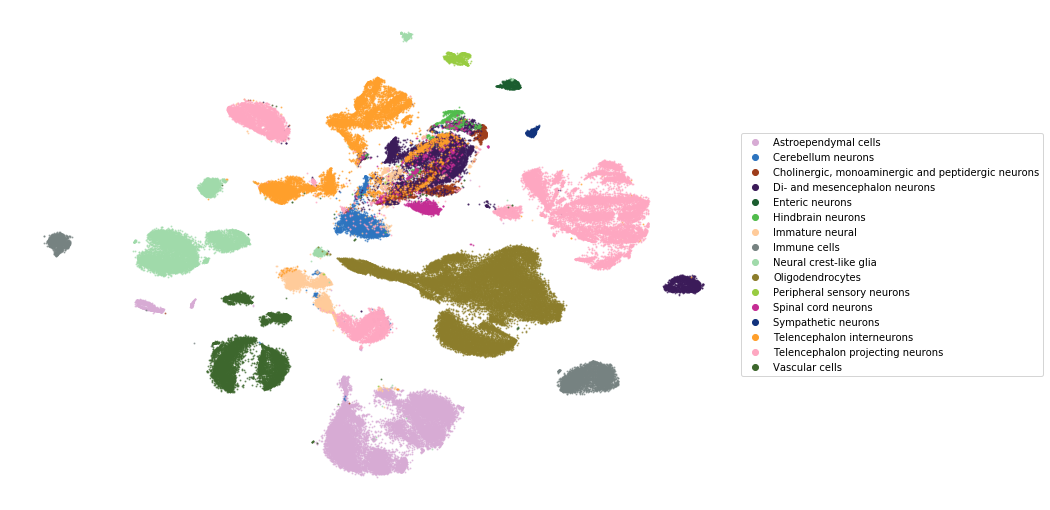

In [14]:
%%time
embedding = TSNEEmbedding(
    initialization.random(x_reduced.shape[0], n_components=2, random_state=np.random.RandomState(42)),
    affinities, negative_gradient_method='fft', learning_rate=1000, n_jobs=8)

embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5, inplace=True)
embedding.optimize(n_iter=1000, momentum=0.8, inplace=True)

utils.plot(embedding, y, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [15]:
ordinary_embedding_500 = embedding.view(np.ndarray)

### Sample + transform

In [39]:
indices = np.random.RandomState(42).permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, y_sample = x_reduced[indices[:25000]], y[indices[:25000]]
x_rest, y_rest = x_reduced[indices[25000:]], y[indices[25000:]]

In [40]:
%time init = initialization.pca(x_sample)

CPU times: user 552 ms, sys: 16 ms, total: 568 ms
Wall time: 94.4 ms


In [41]:
%time affinities = PerplexityBasedNN(x_sample, perplexity=500, method='approx', n_jobs=8)

CPU times: user 5min 8s, sys: 1.37 s, total: 5min 9s
Wall time: 1min 21s


In [42]:
sample_embedding = TSNEEmbedding(
    init, affinities, negative_gradient_method='fft',
    learning_rate=500, n_jobs=8, callbacks=ErrorLogger(),
)

In [43]:
%time sample_embedding1 = sample_embedding.optimize(n_iter=500)

Iteration   50, KL divergence  1.6248, 50 iterations in 5.4902 sec
Iteration  100, KL divergence  1.1036, 50 iterations in 5.4445 sec
Iteration  150, KL divergence  0.9183, 50 iterations in 5.5410 sec
Iteration  200, KL divergence  0.8235, 50 iterations in 5.8950 sec
Iteration  250, KL divergence  0.7690, 50 iterations in 5.8143 sec
Iteration  300, KL divergence  0.7310, 50 iterations in 5.8807 sec
Iteration  350, KL divergence  0.7063, 50 iterations in 6.0369 sec
Iteration  400, KL divergence  0.6884, 50 iterations in 5.9994 sec
Iteration  450, KL divergence  0.6754, 50 iterations in 6.5505 sec
Iteration  500, KL divergence  0.6655, 50 iterations in 5.9735 sec
CPU times: user 7min 48s, sys: 3.3 s, total: 7min 51s
Wall time: 59.1 s


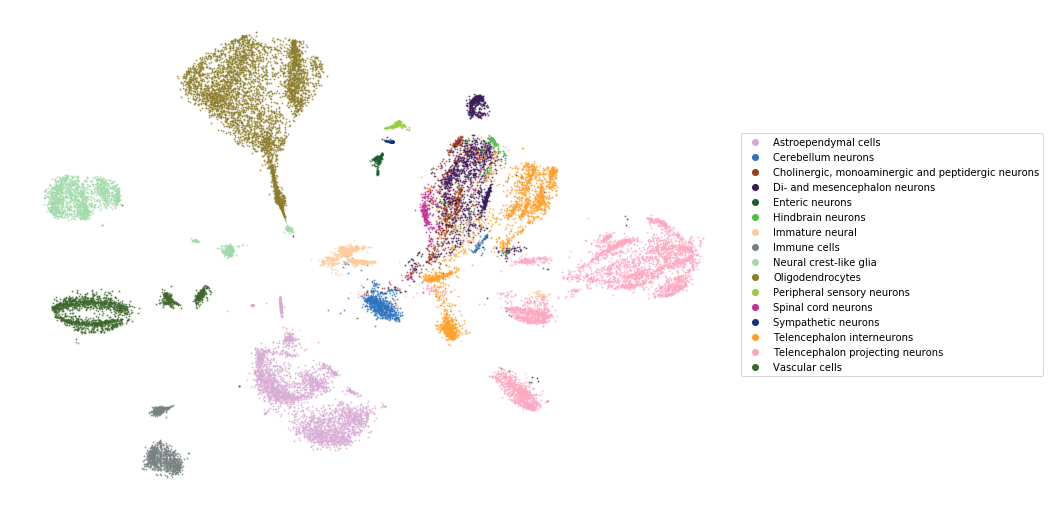

In [44]:
utils.plot(sample_embedding1, y_sample, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [45]:
%time rest_init = sample_embedding1.prepare_partial(x_rest, perplexity=3)

CPU times: user 10 s, sys: 48 ms, total: 10.1 s
Wall time: 4.48 s


In [46]:
x_full = np.vstack((x_sample, x_rest))
y_full = np.hstack((y_sample, y_rest))
init_full = np.vstack((sample_embedding1, rest_init))

In [50]:
x_full = x_full[reverse]
y_full = y_full[reverse]
init_full = init_full[reverse]

In [53]:
%time full_affinities = PerplexityBasedNN(x_full, perplexity=50, method='approx', n_jobs=8)

CPU times: user 3min 1s, sys: 2.62 s, total: 3min 4s
Wall time: 1min 14s


In [62]:
embedding = TSNEEmbedding(
    init_full, full_affinities, negative_gradient_method='fft',
    learning_rate=1000, n_jobs=8, callbacks=ErrorLogger(),
)

In [63]:
%time embedding1 = embedding.optimize(n_iter=1000, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  3.5675, 50 iterations in 6.5972 sec
Iteration  100, KL divergence  3.4631, 50 iterations in 6.0860 sec
Iteration  150, KL divergence  3.4004, 50 iterations in 5.5690 sec
Iteration  200, KL divergence  3.3445, 50 iterations in 6.5093 sec
Iteration  250, KL divergence  3.2878, 50 iterations in 6.5866 sec
Iteration  300, KL divergence  3.2325, 50 iterations in 6.3539 sec
Iteration  350, KL divergence  3.1789, 50 iterations in 6.6469 sec
Iteration  400, KL divergence  3.1291, 50 iterations in 7.4059 sec
Iteration  450, KL divergence  3.0840, 50 iterations in 8.0026 sec
Iteration  500, KL divergence  3.0435, 50 iterations in 8.3102 sec
Iteration  550, KL divergence  3.0071, 50 iterations in 8.3426 sec
Iteration  600, KL divergence  2.9745, 50 iterations in 9.0023 sec
Iteration  650, KL divergence  2.9452, 50 iterations in 9.9497 sec
Iteration  700, KL divergence  2.9190, 50 iterations in 11.7780 sec
Iteration  750, KL divergence  2.8953, 50 iterations in 12.25

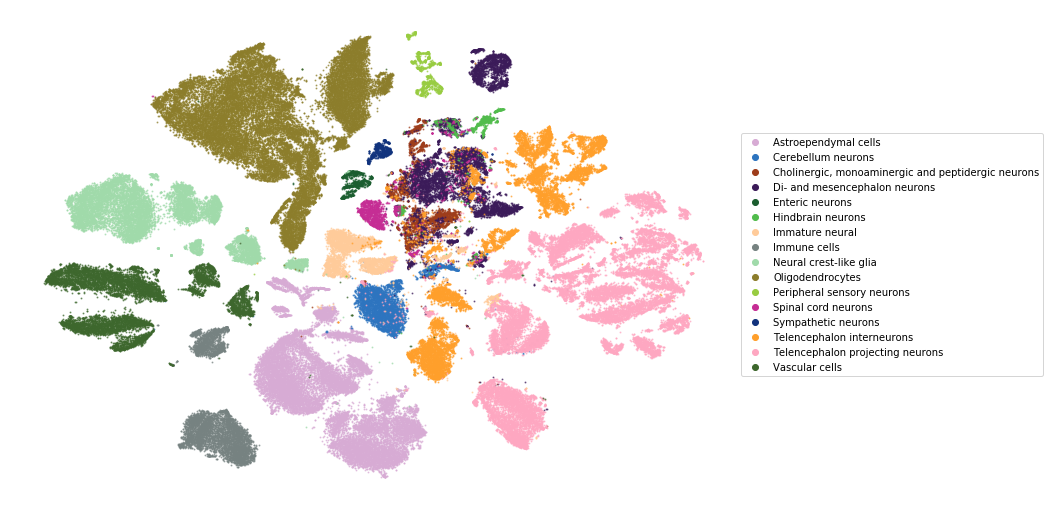

In [64]:
utils.plot(embedding1, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [65]:
sample_embedding = embedding1.view(np.ndarray)

### Multiscale

In [71]:
%time init = initialization.pca(x_reduced)

CPU times: user 2.28 s, sys: 156 ms, total: 2.43 s
Wall time: 406 ms


In [72]:
%time affinities = Multiscale(x_reduced, perplexities=[50, 500], method='approx', n_jobs=8)

CPU times: user 38min 4s, sys: 1min 34s, total: 39min 39s
Wall time: 10min 57s


In [73]:
embedding = TSNEEmbedding(
    init, affinities, negative_gradient_method='fft',
    learning_rate=1000, n_jobs=8, callbacks=ErrorLogger(),
)

In [74]:
%time embedding1 = embedding.optimize(n_iter=750, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  5.3015, 50 iterations in 29.0996 sec
Iteration  100, KL divergence  4.5650, 50 iterations in 28.6809 sec
Iteration  150, KL divergence  4.3430, 50 iterations in 30.2004 sec
Iteration  200, KL divergence  4.2352, 50 iterations in 29.2549 sec
Iteration  250, KL divergence  4.1620, 50 iterations in 28.6163 sec
Iteration  300, KL divergence  4.1256, 50 iterations in 29.3443 sec
Iteration  350, KL divergence  4.0897, 50 iterations in 29.4359 sec
Iteration  400, KL divergence  4.0635, 50 iterations in 29.1292 sec
Iteration  450, KL divergence  4.0302, 50 iterations in 29.5134 sec
Iteration  500, KL divergence  4.0267, 50 iterations in 29.3356 sec
Iteration  550, KL divergence  4.0153, 50 iterations in 29.4545 sec
Iteration  600, KL divergence  3.9921, 50 iterations in 29.0434 sec
Iteration  650, KL divergence  3.9832, 50 iterations in 30.4126 sec
Iteration  700, KL divergence  3.9718, 50 iterations in 29.9948 sec
Iteration  750, KL divergence  3.9646, 50 iterat

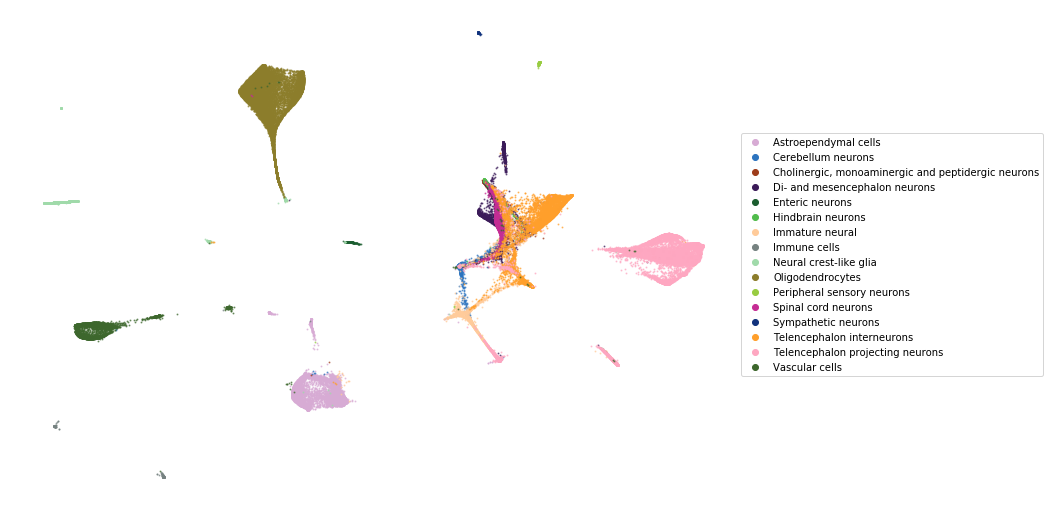

In [75]:
utils.plot(embedding1, y, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [79]:
%time embedding2 = embedding1.optimize(n_iter=1000, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  3.1924, 50 iterations in 29.1546 sec
Iteration  100, KL divergence  2.9228, 50 iterations in 29.0786 sec
Iteration  150, KL divergence  2.7098, 50 iterations in 30.3512 sec
Iteration  200, KL divergence  2.5516, 50 iterations in 30.2337 sec
Iteration  250, KL divergence  2.4343, 50 iterations in 29.2714 sec
Iteration  300, KL divergence  2.3441, 50 iterations in 30.4938 sec
Iteration  350, KL divergence  2.2738, 50 iterations in 30.8689 sec
Iteration  400, KL divergence  2.2177, 50 iterations in 31.5323 sec
Iteration  450, KL divergence  2.1719, 50 iterations in 31.2829 sec
Iteration  500, KL divergence  2.1342, 50 iterations in 31.7163 sec
Iteration  550, KL divergence  2.1028, 50 iterations in 32.5540 sec
Iteration  600, KL divergence  2.0764, 50 iterations in 33.4860 sec
Iteration  650, KL divergence  2.0541, 50 iterations in 32.8353 sec
Iteration  700, KL divergence  2.0353, 50 iterations in 33.7149 sec
Iteration  750, KL divergence  2.0193, 50 iterat

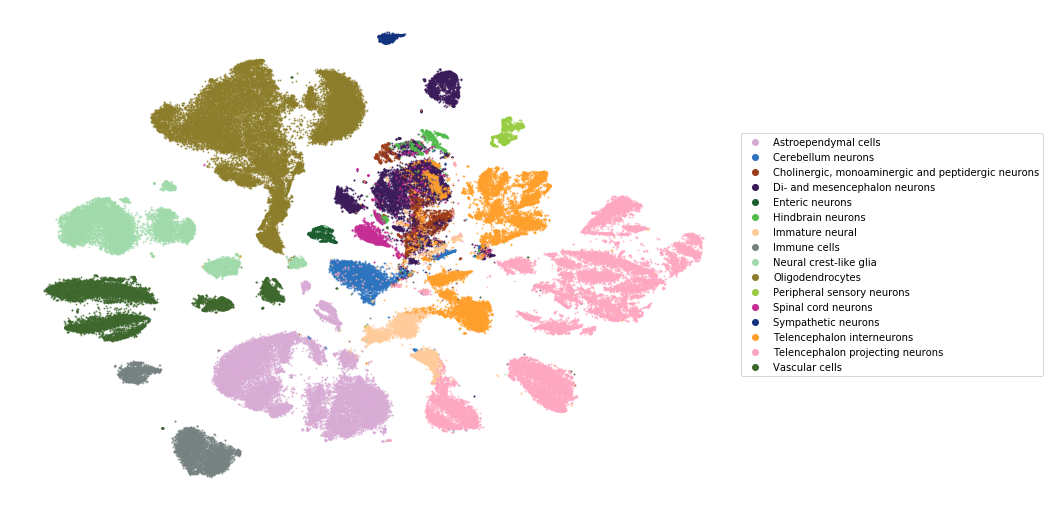

In [80]:
utils.plot(embedding2, y, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [81]:
multiscale_embedding = embedding2.view(np.ndarray)

### Perplexity annealing

In [82]:
%time init = initialization.pca(x_reduced)

CPU times: user 2.15 s, sys: 76 ms, total: 2.23 s
Wall time: 371 ms


In [83]:
%time affinities = PerplexityBasedNN(x_reduced, perplexity=500, method='approx', n_jobs=8)

CPU times: user 33min 39s, sys: 2min 12s, total: 35min 51s
Wall time: 10min 56s


In [84]:
%time affinities.set_perplexity(500)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


In [85]:
embedding = TSNEEmbedding(
    init, affinities, negative_gradient_method='fft',
    learning_rate=1000, n_jobs=8, callbacks=ErrorLogger(),
)

In [86]:
%time embedding1 = embedding.optimize(n_iter=750, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  4.3671, 50 iterations in 29.0653 sec
Iteration  100, KL divergence  3.7081, 50 iterations in 28.8980 sec
Iteration  150, KL divergence  3.5288, 50 iterations in 29.0465 sec
Iteration  200, KL divergence  3.4395, 50 iterations in 28.8904 sec
Iteration  250, KL divergence  3.3766, 50 iterations in 28.5725 sec
Iteration  300, KL divergence  3.3453, 50 iterations in 28.8256 sec
Iteration  350, KL divergence  3.3134, 50 iterations in 29.3564 sec
Iteration  400, KL divergence  3.3029, 50 iterations in 29.1447 sec
Iteration  450, KL divergence  3.2975, 50 iterations in 28.5378 sec
Iteration  500, KL divergence  3.2735, 50 iterations in 28.8535 sec
Iteration  550, KL divergence  3.2668, 50 iterations in 28.7411 sec
Iteration  600, KL divergence  3.2550, 50 iterations in 28.3898 sec
Iteration  650, KL divergence  3.2515, 50 iterations in 29.2148 sec
Iteration  700, KL divergence  3.2439, 50 iterations in 29.1691 sec
Iteration  750, KL divergence  3.2209, 50 iterat

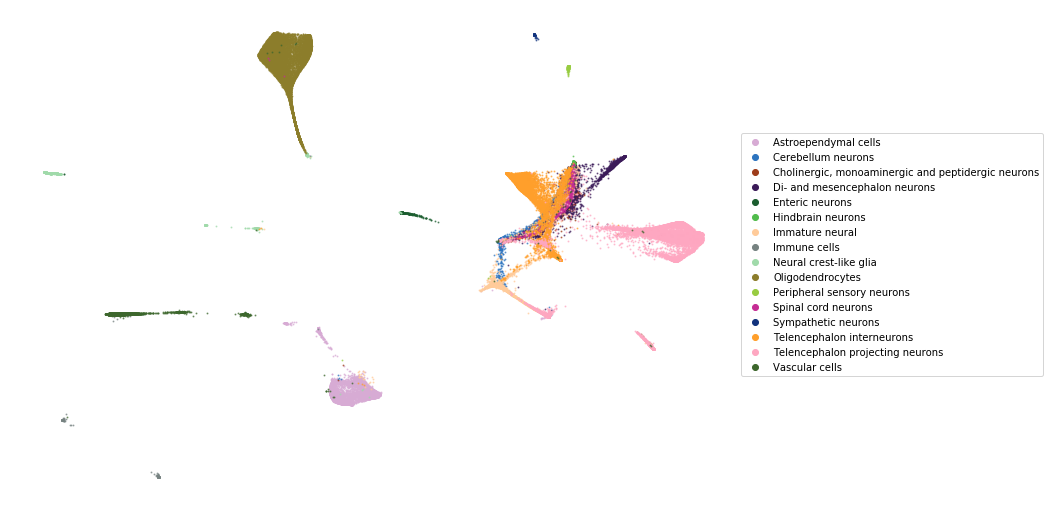

In [87]:
utils.plot(embedding1, y, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [88]:
%time embedding2 = embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.5)

Iteration   50, KL divergence  2.5423, 50 iterations in 29.1516 sec
Iteration  100, KL divergence  2.3373, 50 iterations in 30.4027 sec
Iteration  150, KL divergence  2.1789, 50 iterations in 29.1872 sec
Iteration  200, KL divergence  2.0512, 50 iterations in 30.1521 sec
Iteration  250, KL divergence  1.9483, 50 iterations in 30.4029 sec
Iteration  300, KL divergence  1.8664, 50 iterations in 29.6052 sec
Iteration  350, KL divergence  1.8009, 50 iterations in 29.3506 sec
Iteration  400, KL divergence  1.7449, 50 iterations in 29.9098 sec
Iteration  450, KL divergence  1.6996, 50 iterations in 30.5409 sec
Iteration  500, KL divergence  1.6616, 50 iterations in 29.8158 sec
Iteration  550, KL divergence  1.6287, 50 iterations in 30.5988 sec
Iteration  600, KL divergence  1.6014, 50 iterations in 30.7133 sec
Iteration  650, KL divergence  1.5774, 50 iterations in 30.0793 sec
Iteration  700, KL divergence  1.5569, 50 iterations in 31.3257 sec
Iteration  750, KL divergence  1.5387, 50 iterat

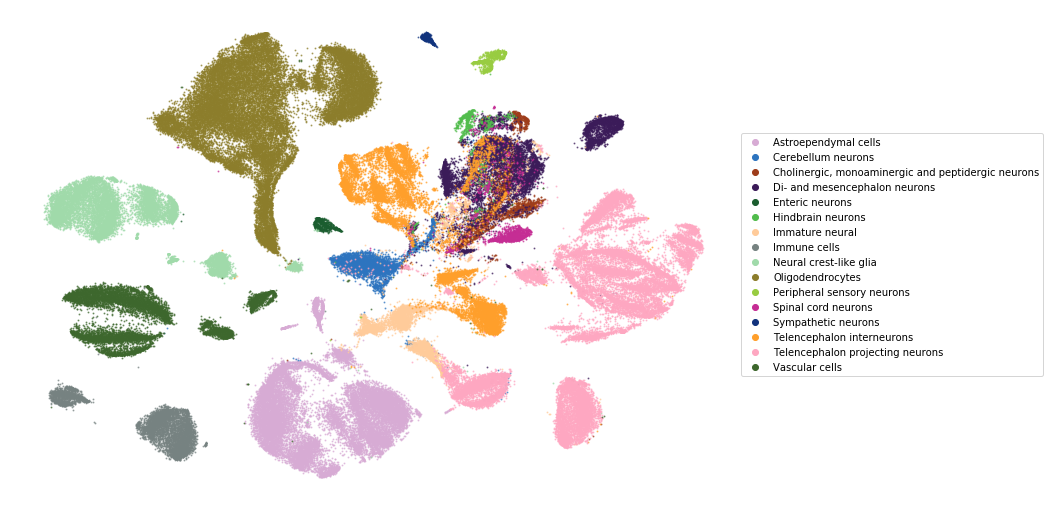

In [89]:
utils.plot(embedding2, y, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [90]:
%time affinities.set_perplexity(50)

CPU times: user 29.1 s, sys: 488 ms, total: 29.6 s
Wall time: 4.27 s


In [91]:
%time embedding3 = embedding2.optimize(n_iter=1500, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  3.1849, 50 iterations in 7.2072 sec
Iteration  100, KL divergence  3.1635, 50 iterations in 6.8647 sec
Iteration  150, KL divergence  3.1378, 50 iterations in 7.2357 sec
Iteration  200, KL divergence  3.1087, 50 iterations in 8.2757 sec
Iteration  250, KL divergence  3.0774, 50 iterations in 8.1145 sec
Iteration  300, KL divergence  3.0457, 50 iterations in 8.3896 sec
Iteration  350, KL divergence  3.0145, 50 iterations in 8.7548 sec
Iteration  400, KL divergence  2.9847, 50 iterations in 8.9934 sec
Iteration  450, KL divergence  2.9566, 50 iterations in 10.1486 sec
Iteration  500, KL divergence  2.9303, 50 iterations in 11.3661 sec
Iteration  550, KL divergence  2.9060, 50 iterations in 10.6805 sec
Iteration  600, KL divergence  2.8840, 50 iterations in 12.0887 sec
Iteration  650, KL divergence  2.8640, 50 iterations in 12.8427 sec
Iteration  700, KL divergence  2.8459, 50 iterations in 10.9404 sec
Iteration  750, KL divergence  2.8296, 50 iterations in 

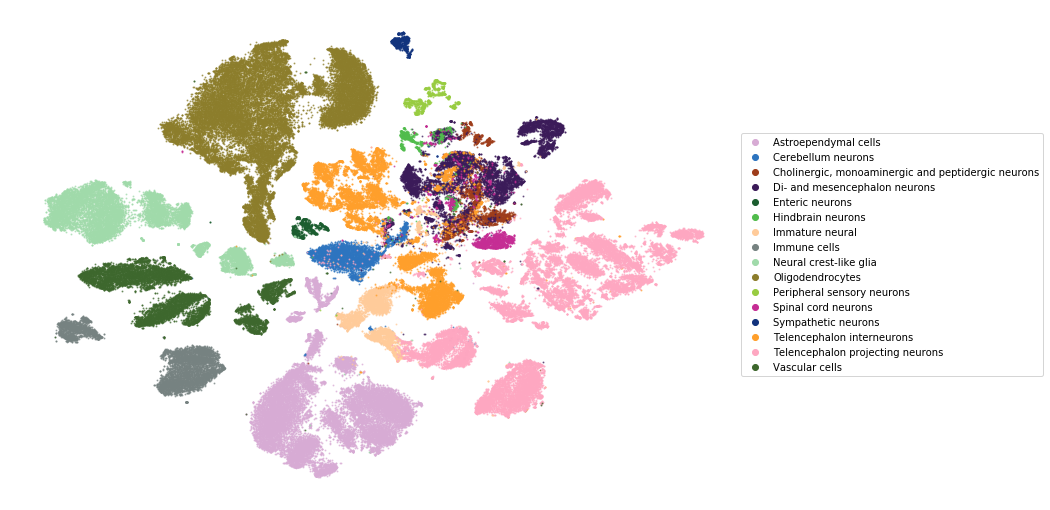

In [92]:
utils.plot(embedding3, y, ax=plt.figure(figsize=(13, 9)).gca(), colors=utils.ZEISEL_COLORS)

In [93]:
annealing_embedding = embedding3.view(np.ndarray)